In [1]:
%load_ext autoreload
%autoreload 2

# Basic Examples

The `dukes100nm_glycerol` folder contains three time series of 100nm (diameter) SiO2 nanoparticles dispersed in a glycerol-water mixture. 

This tutorial shows how to:
1. Load data and define the setup.
2. Process the datasets and calculate:
    * The azimuthally integrated SAXS curves
    * XPCS intensity auto-correlation functions
    * XSVS photon statistics
3. Display and fit the correlation functions.
4. Working with the database:
    * Display entries
    * Select measurements
    * Discard measurements
5. Determine the viscosity of the solution.

**Importing Xana and Setting up the Figure Style**

In [2]:
from Xana import Xana

import numpy as np
import seaborn as sns

sns.set_style('ticks', rc={'figure.dpi':300})
sns.set_context('notebook')

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('png')

## Downloading Data

In [3]:
!wget https://github.com/reiserm/Xana_example/raw/master/xpcs_data.tgz -O xpcs_data.tgz -q

In [4]:
import hashlib
hashlib.md5(open('xpcs_data.tgz','rb').read()).hexdigest()

'76022d60f4a367ff38e8c515b2e3c61c'

In [5]:
!tar -xzf xpcs_data.tgz

# Loading Data and Defineing the Setup

For each type of analysis a *setupfile* is required that contains information about the geometry (sample-detector distance, wavelength, etc.) but also about the ROIs where the XPCS and XSVS analysis will be performed.

In [6]:
d = Xana(fmtstr='id10_eiger_single_edf', # format string that defines how the date are read
         sample='100nm-SiO2', # optional: sample name used in data base
         maskfile='./mask_array.npy', # optional: file that conatains the blemish / mask
         detector='eiger500k') # specify the detector

By connecting the Xana instance to a directory that folder is searched for datasets and corresponding metadata information. The information are received based on the `fmtstr` keyword. Here, we use "id10_eiger_single_edf" as the example data were measured at ID10 at the ESRF. See the [Xana Documentation](https://xana.readthedocs.io/en/latest/) for further details. The metadata are stored in the `meta` attribute. 


In [7]:
d.connect('./dukes100nm_glycerol/xpcs/exp320us_att0/')
d.meta

,series,t_exposure,t_readout,t_latency,nframes,first,last,master,datdir
0,1,0.00032,0.00001,0.0,1500,0,1499,img_eiger_0001_0000_0000.edf.gz,/home/roscar/work/xana/docs/source/dukes100nm_...
1,2,0.00032,0.00001,0.0,1500,0,1499,img_eiger_0002_0000_0000.edf.gz,/home/roscar/work/xana/docs/source/dukes100nm_...
2,3,0.00032,0.00001,0.0,1500,0,1499,img_eiger_0003_0000_0000.edf.gz,/home/roscar/work/xana/docs/source/dukes100nm_...


<!-- The columns are -->

<!-- | Column        | Description   |
| ------------- |---------------|
| col 3 is      | right-aligned |
| col 2 is      | centered      |
| zebra stripes | are neat      | -->

Now the data can be loaded using the `get_series`-method. **All** Xana methods that process data take the index of the metadata table as first argument. 

The data can be loaded into a 3D-array setting the `method` keyword to `'full'` (default). The dimensions are (time x Pixel-X x Pixel-Y). For demonstration purposes, we read only the first 100 images by setting the `last` keyword to 100. The first image (with index 0) is skipped by setting the `first` keyword to 1. In general, the `first` and `last` keywords can be used to analyse subsets of a time series.

In [8]:
data = d.get_series(0, method='full', verbose=True, first=1, last=100)
print('The returned array has the dimensions: ', data.shape)

First images is:  1
Last image is:  100
Loading data in chunks of 256 images.
[============================================================] 100.0%
The returned array has the dimensions:  (100, 514, 1030)


To define the ROIs for the XPCS/XSVS analysis, the data are averaged over the time axis. The command is the same except the `method`-keyword has been changed to `'average'`. Then, the function returns a list containing the average intensity, `I`, and the variance, `V`.

In [9]:
I, V = d.get_series(0, method='average', verbose=False, first=1)

[============================================================] 100.0%


Now the setup can be defined. If no dictionary is passed to the `make_setup` method, the user is prompted to input the parameters. The vector `qv_init` contains a list of tuples. Each tuple should have the q position (or an array of q positions) as first element and the q width as second argument.

The `defineqrois` method requires an image, `I`, and the `qv_init` list as input parameters. Using the `phiv_init` keyword, angular slices (in degrees) can be selected.

Added the following Q-values [nm-1]:
[0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06  0.065 0.07  0.075 0.125]


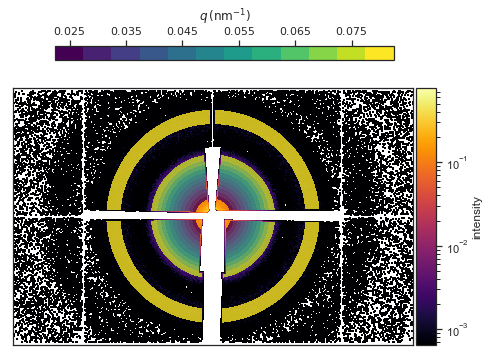

In [10]:
d.setup.make(**{'center': [516, 257], # position of the direct beam in pixels
                'wavelength': 1.5, # X-ray wavelength in Angstrom
                'distance': 5 # sample-detector distance in m
               }
            )

# q-vector and width in nm-1
qv_init = [(np.arange(0.025, 0.08, .005), .008),
           (.125, .02)]

# anglular slices in degress (10, 150) with a width of 30 degrees
phiv_init = [([10, 150], 30)]

d.defineqrois(I, qv_init=qv_init, plot='ROIS', d=400)#, mirror=True, phiv_init=phiv_init,)

The setup can be saved to load it from different notebooks or scripts. The `maksavdir` method can be used to create directories for saving setupfiles or other results. It creates a new subfolder `setupfiles` (first argument) in the folder specified by the second argument, here in the present folder `./`. Prefix and suffix are added automatically. If a file with the same name already exists, the user is asked if he or she wants to override it.

In [11]:
d.mksavdir('setupfiles', './')
d.savesetup('100nm', handle_existing='overwrite')

Changing savdir to:
	/home/roscar/work/xana/docs/source/setupfiles/
Try loading database:
	/home/roscar/work/xana/docs/source/setupfiles/Analysis_db.pkl
	...loading database failed.

Results saved to:
	/home/roscar/work/xana/docs/source/setupfiles/setup_100nm.pkl


# Processing Data

We follow the same steps as before to initialize a Xana instance; however, now we load the previously defined and saved setupfile. 

In [12]:
d = Xana(fmtstr='id10_eiger_single_edf', # format string that defines how data are read
         sample='100nm-SiO2', # optional: sample name used in data base
         setupfile='./setupfiles/setup_100nm.pkl',) # we load the previously defined setup

Loaded setupfile:
	/home/roscar/work/xana/docs/source/setupfiles/setup_100nm.pkl.


The setupfile can also be loaded separately:

In [13]:
d.loadsetup('./setupfiles/setup_100nm.pkl')

Loaded setupfile:
	/home/roscar/work/xana/docs/source/setupfiles/setup_100nm.pkl.


Again we connect Xana to the directory containing the data:

In [14]:
d.connect('./dukes100nm_glycerol/xpcs/exp320us_att0/')
d.meta

,series,t_exposure,t_readout,t_latency,nframes,first,last,master,datdir
0,1,0.00032,0.00001,0.0,1500,0,1499,img_eiger_0001_0000_0000.edf.gz,/home/roscar/work/xana/docs/source/dukes100nm_...
1,2,0.00032,0.00001,0.0,1500,0,1499,img_eiger_0002_0000_0000.edf.gz,/home/roscar/work/xana/docs/source/dukes100nm_...
2,3,0.00032,0.00001,0.0,1500,0,1499,img_eiger_0003_0000_0000.edf.gz,/home/roscar/work/xana/docs/source/dukes100nm_...


As each run of the analysis routines creates a separate file, we want to create a new directory for the results. Again we can use the `mksavdir` command.

In [15]:
d.mksavdir('100nm_glycerol', './')

Changing savdir to:
	/home/roscar/work/xana/docs/source/100nm_glycerol/
Try loading database:
	/home/roscar/work/xana/docs/source/100nm_glycerol/Analysis_db.pkl
Successfully loaded database


The results of the analysis are stored (pickled) as dictionaries containing all necessary information on the analysis. Additionally, an entry is added in the analysis **database**. The default file is `Analysis_db.pkl`. If that file does not exist, the database has to be initialized **after** connecting with a dataset. That is because the columns of the database are taken from the metadata table.

In [16]:
d.init_db(handle_existing='overwrite')


Results saved to:
	/home/roscar/work/xana/docs/source/100nm_glycerol/Analysis_db.pkl


Different types of analysis can be performed as shown in the next cell using the `analyze` method.
* As for loading the data, the first argument is the index of the metadata table and defines the series you want to analyze. -1 means that every series of the metadata tabel is analyzed.
* The second argument defines the type of analysis:
    * **xpcs** uses pyxpcs to calcualte intensity auto-correlation functions
    * **xpcs_evt** uses the eventcorrelator to calculate correlation functions
    * **saxs** computes the azimuthally integrated intensity
    * **xsvs** calculates the photon probabilities
* Other kwargs are specific for a specific type of analysis. Again the reader is refferred to the [Xana Documentation](https://xana.readthedocs.io/en/latest/) for further information.

**SAXS Azimuthal Intensity**

In [17]:
d.analyze(-1, 'saxs', verbose=True, first=1, last=500)



#### Starting saxs Analysis ####
Series: 0 in folder /home/roscar/work/xana/docs/source/dukes100nm_glycerol/xpcs/exp320us_att0/

Using 1 processes to read data.
[============================================================] 100.0%

Results saved to:
	/home/roscar/work/xana/docs/source/100nm_glycerol/saxs_exp320us_att0_s1_0016.pkl

Results saved to:
	/home/roscar/work/xana/docs/source/100nm_glycerol/Analysis_db.pkl


#### Starting saxs Analysis ####
Series: 1 in folder /home/roscar/work/xana/docs/source/dukes100nm_glycerol/xpcs/exp320us_att0/

Using 1 processes to read data.
[============================================================] 100.0%

Results saved to:
	/home/roscar/work/xana/docs/source/100nm_glycerol/saxs_exp320us_att0_s2_0016.pkl

Results saved to:
	/home/roscar/work/xana/docs/source/100nm_glycerol/Analysis_db.pkl


#### Starting saxs Analysis ####
Series: 2 in folder /home/roscar/work/xana/docs/source/dukes100nm_glycerol/xpcs/exp320us_att0/

Using 1 processes to read dat

**XPCS Correlation Functions**

In [18]:
d.analyze(-1, 'xpcs', verbose=True, first=1, twotime_par=1)



#### Starting xpcs Analysis ####
Series: 0 in folder /home/roscar/work/xana/docs/source/dukes100nm_glycerol/xpcs/exp320us_att0/

Using 1 processes to read data.
Calculating average SAXS image.
[============================================================] 100.0%
Number of images is: 1499
shape of image section is: (429, 430)
Start computing SAXS for normalization.
Done
Shape of saxs_img: (429, 430)
Sum of saxs_img: 21596.95
Number of ROIs:  12
Using 2 processes.
Number of registers is 8 with 72 total correlation points.
[============================================================] 100.0%
Finished calculating correlation functions.
Start calculating TRC and Chi4...
Elapsed time: 0.57 min
Elapsed time for correlate: 0.48 min
Elapsed time for TRC and Chi4: 0.03 min

Results saved to:
	/home/roscar/work/xana/docs/source/100nm_glycerol/xpcs_exp320us_att0_s1_0028.pkl

Results saved to:
	/home/roscar/work/xana/docs/source/100nm_glycerol/Analysis_db.pkl


#### Starting xpcs Analysis ####
Se

**XPCS Eventcorrelator**

In [19]:
d.analyze(-1, 'xpcs_evt', verbose=True, first=1,)



#### Starting xpcs_evt Analysis ####
Series: 0 in folder /home/roscar/work/xana/docs/source/dukes100nm_glycerol/xpcs/exp320us_att0/

Using 1 processes to read data.
First images is:  1
Last image is:  1499
Loading data in chunks of 200 images.
[============================================================] 100.0%

Analyzing ROI: 0
starting fortran routine

Analyzing ROI: 1
starting fortran routine

Analyzing ROI: 2
starting fortran routine

Analyzing ROI: 3
starting fortran routine

Analyzing ROI: 4
starting fortran routine

Analyzing ROI: 5
starting fortran routine

Analyzing ROI: 6
starting fortran routine

Analyzing ROI: 7
starting fortran routine

Analyzing ROI: 8
starting fortran routine

Analyzing ROI: 9
starting fortran routine

Analyzing ROI: 10
starting fortran routine

Analyzing ROI: 11
starting fortran routine

Results saved to:
	/home/roscar/work/xana/docs/source/100nm_glycerol/xpcs_evt_exp320us_att0_s1_0015.pkl

Results saved to:
	/home/roscar/work/xana/docs/source/100nm_

**XSVS Photon Probabilities**

In [20]:
d.analyze(-1, 'xsvs', verbose=True, first=1, nbins=64, nprocs=4)



#### Starting xsvs Analysis ####
Series: 0 in folder /home/roscar/work/xana/docs/source/dukes100nm_glycerol/xpcs/exp320us_att0/

Using 1 processes to read data.
Number of images is: 1499
Loading data in chunks.
Number of ROIs:  12
Using 4 processes.
[============================================================] 100.0%
Finished calculating correlation functions.
Elapsed time: 0.15 min
Elapsed time for calulating probabilities: 0.14 min

Results saved to:
	/home/roscar/work/xana/docs/source/100nm_glycerol/xsvs_exp320us_att0_s1_0015.pkl

Results saved to:
	/home/roscar/work/xana/docs/source/100nm_glycerol/Analysis_db.pkl


#### Starting xsvs Analysis ####
Series: 1 in folder /home/roscar/work/xana/docs/source/dukes100nm_glycerol/xpcs/exp320us_att0/

Using 1 processes to read data.
Number of images is: 1499
Loading data in chunks.
Number of ROIs:  12
Using 4 processes.
[============================================================] 100.0%
Finished calculating correlation functions.
Elapse

## The Database

The results are storred in the previously defined `'100nm_glycerol'` directory. We see the file of the analysis database `Analysis_db.pkl` and a file for each analysis type and dataset (9 files in total). The file name starts with the name of the performed analysis type (saxs, xpcs, xsvs,...).

In [21]:
d.analyze(-1, 'xpcs', verbose=True, first=1, twotime_par=1)



#### Starting xpcs Analysis ####
Series: 0 in folder /home/roscar/work/xana/docs/source/dukes100nm_glycerol/xpcs/exp320us_att0/

Using 1 processes to read data.
Calculating average SAXS image.
[============================================================] 100.0%
Number of images is: 1499
shape of image section is: (429, 430)
Start computing SAXS for normalization.
Done
Shape of saxs_img: (429, 430)
Sum of saxs_img: 21596.95
Number of ROIs:  12
Using 2 processes.
Number of registers is 8 with 72 total correlation points.
[============================================================] 100.0%
Finished calculating correlation functions.
Start calculating TRC and Chi4...
Elapsed time: 0.50 min
Elapsed time for correlate: 0.41 min
Elapsed time for TRC and Chi4: 0.03 min

Results saved to:
	/home/roscar/work/xana/docs/source/100nm_glycerol/xpcs_exp320us_att0_s1_0029.pkl

Results saved to:
	/home/roscar/work/xana/docs/source/100nm_glycerol/Analysis_db.pkl


#### Starting xpcs Analysis ####
Se

**XPCS Eventcorrelator**

In [22]:
from Xana import Xana

In [23]:
d = Xana(setupfile='./setupfiles/setup_100nm.pkl')
d.load_db('./test/Analysis_db.pkl')

# the database
d.db

Loaded setupfile:
	/home/roscar/work/xana/docs/source/setupfiles/setup_100nm.pkl.
Try loading database:
	/home/roscar/work/xana/docs/source/test/Analysis_db.pkl
	...loading database failed.


# Data Interpretation

The `Xana` module provides different submodules for data interpretation. In particular:
* `Soq` for displaying SAXS data.
* `CorrFunc` for analyising XPCS correlation functions.
* `VisbFunc` for plotting photon statistics.

## Loading Data Base

In [24]:
from Xana import Xana

In [25]:
d = Xana(setupfile='./setupfiles/setup_100nm.pkl')
d.load_db('./100nm_glycerol/Analysis_db.pkl')

Loaded setupfile:
	/home/roscar/work/xana/docs/source/setupfiles/setup_100nm.pkl.
Try loading database:
	/home/roscar/work/xana/docs/source/100nm_glycerol/Analysis_db.pkl
Successfully loaded database


The database can be accessed by the `db` attribute of the Xana instance.

In [26]:
d.db

,use,sample,analysis,series,t_exposure,t_readout,t_latency,nframes,first,last,master,datdir,mod,savname,savfile,setupfile,comment
0,True,100nm-SiO2,saxs,1,0.00032,0.00001,0.0,499,1,499,img_eiger_0001_0000_0000.edf.gz,/home/roscar/work/xana/docs/source/dukes100nm_...,2020-07-22 12:51:33.769054,saxs_exp320us_att0_s1_0016.pkl,/home/roscar/work/xana/docs/source/100nm_glyce...,/home/roscar/work/xana/docs/source/setupfiles/...,
1,True,100nm-SiO2,saxs,2,0.00032,0.00001,0.0,499,1,499,img_eiger_0002_0000_0000.edf.gz,/home/roscar/work/xana/docs/source/dukes100nm_...,2020-07-22 12:51:36.355337,saxs_exp320us_att0_s2_0016.pkl,/home/roscar/work/xana/docs/source/100nm_glyce...,/home/roscar/work/xana/docs/source/setupfiles/...,
2,True,100nm-SiO2,saxs,3,0.00032,0.00001,0.0,499,1,499,img_eiger_0003_0000_0000.edf.gz,/home/roscar/work/xana/docs/source/dukes100nm_...,2020-07-22 12:51:39.075251,saxs_exp320us_att0_s3_0016.pkl,/home/roscar/work/xana/docs/source/100nm_glyce...,/home/roscar/work/xana/docs/source/setupfiles/...,
3,True,100nm-SiO2,xpcs,1,0.00032,0.00001,0.0,1499,1,1499,img_eiger_0001_0000_0000.edf.gz,/home/roscar/work/xana/docs/source/dukes100nm_...,2020-07-22 12:52:23.939154,xpcs_exp320us_att0_s1_0028.pkl,/home/roscar/work/xana/docs/source/100nm_glyce...,/home/roscar/work/xana/docs/source/setupfiles/...,
4,True,100nm-SiO2,xpcs,2,0.00032,0.00001,0.0,1499,1,1499,img_eiger_0002_0000_0000.edf.gz,/home/roscar/work/xana/docs/source/dukes100nm_...,2020-07-22 12:53:06.507557,xpcs_exp320us_att0_s2_0027.pkl,/home/roscar/work/xana/docs/source/100nm_glyce...,/home/roscar/work/xana/docs/source/setupfiles/...,
5,True,100nm-SiO2,xpcs,3,0.00032,0.00001,0.0,1499,1,1499,img_eiger_0003_0000_0000.edf.gz,/home/roscar/work/xana/docs/source/dukes100nm_...,2020-07-22 12:53:50.018176,xpcs_exp320us_att0_s3_0027.pkl,/home/roscar/work/xana/docs/source/100nm_glyce...,/home/roscar/work/xana/docs/source/setupfiles/...,
6,True,100nm-SiO2,xpcs_evt,1,0.00032,0.00001,0.0,1499,1,1499,img_eiger_0001_0000_0000.edf.gz,/home/roscar/work/xana/docs/source/dukes100nm_...,2020-07-22 12:54:03.371195,xpcs_evt_exp320us_att0_s1_0015.pkl,/home/roscar/work/xana/docs/source/100nm_glyce...,/home/roscar/work/xana/docs/source/setupfiles/...,
7,True,100nm-SiO2,xpcs_evt,2,0.00032,0.00001,0.0,1499,1,1499,img_eiger_0002_0000_0000.edf.gz,/home/roscar/work/xana/docs/source/dukes100nm_...,2020-07-22 12:54:16.620719,xpcs_evt_exp320us_att0_s2_0015.pkl,/home/roscar/work/xana/docs/source/100nm_glyce...,/home/roscar/work/xana/docs/source/setupfiles/...,
8,True,100nm-SiO2,xpcs_evt,3,0.00032,0.00001,0.0,1499,1,1499,img_eiger_0003_0000_0000.edf.gz,/home/roscar/work/xana/docs/source/dukes100nm_...,2020-07-22 12:54:29.254569,xpcs_evt_exp320us_att0_s3_0015.pkl,/home/roscar/work/xana/docs/source/100nm_glyce...,/home/roscar/work/xana/docs/source/setupfiles/...,
9,True,100nm-SiO2,xsvs,1,0.00032,0.00001,0.0,1499,1,1499,img_eiger_0001_0000_0000.edf.gz,/home/roscar/work/xana/docs/source/dukes100nm_...,2020-07-22 12:54:40.109798,xsvs_exp320us_att0_s1_0015.pkl,/home/roscar/work/xana/docs/source/100nm_glyce...,/home/roscar/work/xana/docs/source/setupfiles/...,


## SAXS

In [27]:
from Xana import Soq

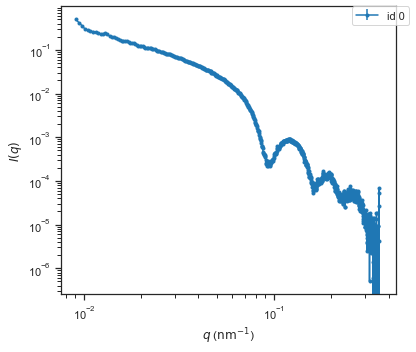

In [28]:
s = Soq(d)
s.plot_soq(0, Ae=0)

## XPCS

In [29]:
from Xana import CorrFunc
import numpy as np

In [30]:
d.db['use'] = True

Merged g2 functions:  [0.00032] (exposure times)
                      [6] (number of correlation functions)
                      [8994] (total number of images)
Optimizing...(0)Fit successful: True


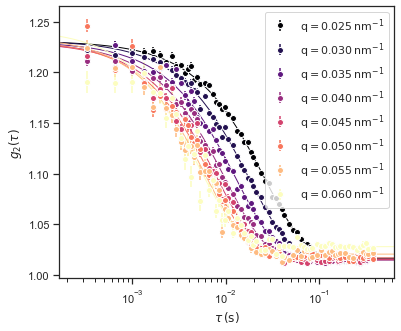

In [31]:
# initializing CorrFunc instance
g = CorrFunc(d)

# searching data base for xpcs measurements
ind = d.db[(d.db['analysis'] == 'xpcs')
          &(d.db['use'] == True)].index.values

#loading correlation functions
g.get_g2(ind, merge='merge')

# plotting
g.nq = np.arange(8)
g.plot_g2(doplot='data_legq_fit', color_mode=1, dofit=1, fix={}, init={'t0':(.02,0, None)}, 
          fitglobal=['g0','beta'])

In [32]:
d.discard_entry(3)


Results saved to:
	/home/roscar/work/xana/docs/source/100nm_glycerol/Analysis_db.pkl


In [33]:
g.rescale(normby='fit', norm_contrast=True, contrast=1, baseline=1)

Optimizing...(0)Fit successful: True


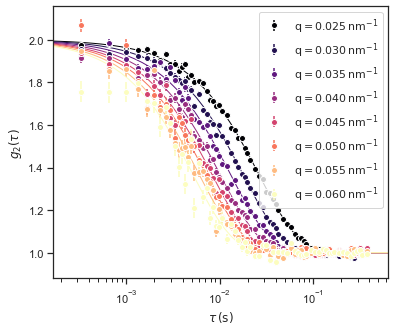

In [34]:
g.plot_g2(doplot='data_fit_legq', dofit=True, 
          fix={'a':1, 'g0':1, 'beta':1},)# init={'beta':(1,0,1), 't0':(.01,None,None), 'g0':(1,None,None)})

## Eventcorrelator

Merged g2 functions:  [0.00032] (exposure times)
                      [2] (number of correlation functions)
                      [2998] (total number of images)
Optimizing...(0)Fit successful: True


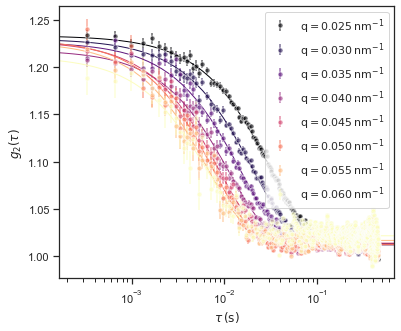

In [35]:
ge = CorrFunc(d)
ind = d.db[(d.db['analysis']=='xpcs_evt')
          &(d.db['use'])].index.values
ge.get_g2(ind, merge='merge')
ge.nq = np.arange(8)
ge.plot_g2(doplot='data_fit_legq', change_marker=1, markersize=5, alpha=.6, dofit=True, 
          fix={'g0':1,}, mode='semilogx', color_mode=0)

In [36]:
ge.rescale(normby='fit', norm_contrast=True, contrast=1, baseline=1)

Optimizing...(0)Fit successful: True


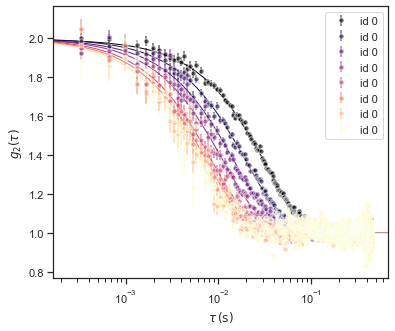

In [37]:
ge.plot_g2(doplot='data_fit_legd', change_marker=1, markersize=5, alpha=.6, dofit=True, 
          fix={'g0':1,}, mode='semilogx', color_mode=0)

### Comparing results from pyxpcs and eventcorrelator

In [38]:
gs = g + ge

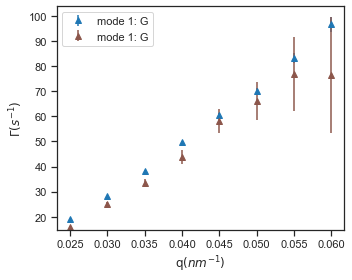

In [39]:
gs.plot_parameters(['G'], modes=(1,))

In [40]:
gs.pars[0]

,q,t0,dt0,g0,dg0,b0,db0,a,da,beta,dbeta,chisqr,redchi,bic,aic
0,0.025,0.052504,0.000375,1,0.0,1,0.0,1,0.0,1,0.0,856.958644,1.647997,305.859673,271.706903
1,0.030,0.035498,0.000283,1,0.0,1,0.0,1,0.0,1,0.0,856.958644,1.647997,305.859673,271.706903
2,0.035,0.026121,0.000242,1,0.0,1,0.0,1,0.0,1,0.0,856.958644,1.647997,305.859673,271.706903
3,0.040,0.020158,0.000227,1,0.0,1,0.0,1,0.0,1,0.0,856.958644,1.647997,305.859673,271.706903
4,0.045,0.016537,0.000230,1,0.0,1,0.0,1,0.0,1,0.0,856.958644,1.647997,305.859673,271.706903
5,0.050,0.014273,0.000251,1,0.0,1,0.0,1,0.0,1,0.0,856.958644,1.647997,305.859673,271.706903
6,0.055,0.012029,0.000278,1,0.0,1,0.0,1,0.0,1,0.0,856.958644,1.647997,305.859673,271.706903
7,0.060,0.010346,0.000325,1,0.0,1,0.0,1,0.0,1,0.0,856.958644,1.647997,305.859673,271.706903


**Remark**: From here, the documentation is work-in-progress and gives some examples of additional features.

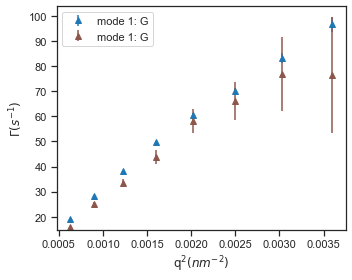

In [41]:
gs.plot_parameters(['G'], 
                   modes=([1],[1],),
                   alpha=(2,1,),)
#                    fit=('line',''),
#                    fix=({'b':0}),
#                    R=50e-9, viscosity=1, 
#                    fit_report=1);


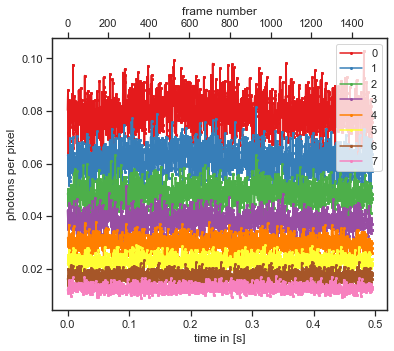

In [42]:
g.plot_trace(4)

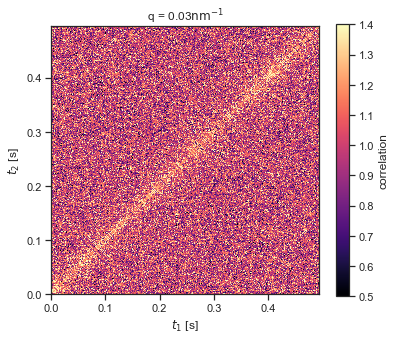

In [43]:
g.plot_twotime([3,4,5], interpolation='nearest', clim=(0.5,1.4))

## XSVS

In [44]:
from Xana import VisbFunc

Loaded probabilities of 2 series.


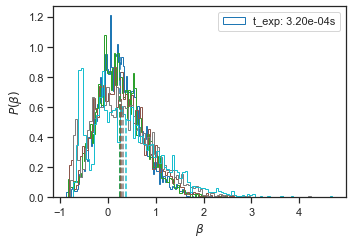

In [45]:
# initializing Visibility Func instance
v = VisbFunc(d)

# searching data base for xsvs results
ind = d.db[(d.db['analysis']=='xsvs')
          &(d.db['use'])].index.values

# loading probablities
v.get_prob(ind, merge=True)

# calculating contrast
v.calculate_contrast()

# plot histogram
v.quicklook(plot=['pbb'], nq=np.arange(5), color_mode=0, ratio=0, cmap='tab10', alpha=0.2)  

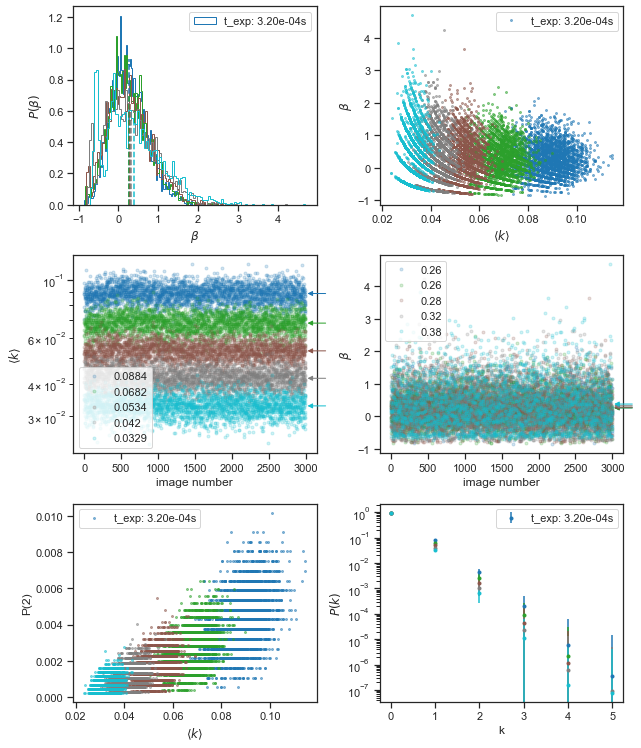

In [46]:
v.quicklook(plot=['pbb','bvkb', 'kbvi', 'bvi', 'pkvkb', 'pbk'],
                      idx=None, nq=np.arange(5), change_marker=0,
                       color_mode=1, maxlen=np.inf, ratio=0, probk=2,
                       cmap='tab10', lfs=8, total_counts=False, alpha=0.2)